# Title: IP Explorer
&lt;details&gt;
    <summary> <u>Details...</u></summary>
    
**Notebook Version:** 1.0<br>
**Python Version:** Python 3.7 (including Python 3.6 - AzureML)<br>
**Required Packages**: kqlmagic, msticpy, pandas, numpy, matplotlib, networkx, ipywidgets, ipython, scikit_learn, dnspython, ipwhois, folium, holoviews<br>
**Platforms Supported**:
- Azure Notebooks Free Compute
- Azure Notebooks DSVM
- OS Independent

**Data Sources Required**:
- Log Analytics 
    - Heartbeat
    - SecurityAlert
    - SecurityEvent
    - AzureNetworkAnalytics_CL
    
- (Optional)  
    - VirusTotal (with API key)
    - Alienvault OTX (with API key) 
    - IBM Xforce (with API key) 
    - CommonSecurityLog
&lt;/details&gt;


Brings together a series of queries and visualizations to help you assess the security state of an IP address. It works with both internal addresses and public addresses. 
<br> For internal addresses it focuses on traffic patterns and behavior of the host using that IP address. For public IPs it lets you perform threat intelligence lookups, passive dns, whois and other checks. 
<br>It also allows you to examine any network traffic between the external IP address and your resources.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a><span class="toc-item-num">1  </span>Hunting Hypothesis</a></span><ul class="toc-item"><li><span><a><span class="toc-item-num">1.1  </span>IP Explorer Mindmap</a></span></li></ul></li><li><span><a><span class="toc-item-num">2  </span>Notebook Initialization</a></span><ul class="toc-item"><li><span><a><span class="toc-item-num">2.1  </span>Get WorkspaceId and Authenticate to Log Analytics</a></span></li></ul></li><li><span><a><span class="toc-item-num">3  </span>Detemine IP Address Type</a></span></li><li><span><a><span class="toc-item-num">4  </span>System Info</a></span></li><li><span><a><span class="toc-item-num">5  </span>ServiceMap - Get List of Services for Host</a></span></li><li><span><a><span class="toc-item-num">6  </span>GeoIP Lookups for External IP Addresses</a></span></li><li><span><a><span class="toc-item-num">7  </span><font>IH Comment</font></a></span></li><li><span><a><span class="toc-item-num">8  </span>Whois Registrars for External IP Addresses</a></span></li><li><span><a><span class="toc-item-num">9  </span>Opensource and Azure Sentinel ThreatIntel Lookups</a></span><ul class="toc-item"><li><span><a><span class="toc-item-num">9.1  </span>Configure your TI Provider settings</a></span></li></ul></li><li><span><a><span class="toc-item-num">10  </span>Passive DNS lookups for External IP Addresses</a></span></li><li><span><a><span class="toc-item-num">11  </span>Visualization - Timeline of Related Alerts</a></span></li><li><span><a><span class="toc-item-num">12  </span>Browse List of Related Alerts</a></span></li><li><span><a><span class="toc-item-num">13  </span>Visualization - Networkx Graph</a></span><ul class="toc-item"><li><span><a><span class="toc-item-num">13.1  </span>IH Comment - no labels on IP Addresses (not super important)</a></span></li></ul></li><li><span><a><span class="toc-item-num">14  </span>Visualization - Networkx Graph</a></span></li><li><span><a><span class="toc-item-num">15  </span>HeatMap for Weekly failed logons</a></span></li><li><span><a><span class="toc-item-num">16  </span>Host Logons Timeline</a></span></li><li><span><a><span class="toc-item-num">17  </span>Failed Logons Timeline</a></span></li><li><span><a><span class="toc-item-num">18  </span>Network Check Communications with Other Hosts</a></span><ul class="toc-item"><li><span><a><span class="toc-item-num">18.1  </span>Query Flows by IP Address</a></span></li><li><span><a><span class="toc-item-num">18.2  </span>Choose ASNs/IPs to Check for Threat Intel Reports</a></span></li></ul></li><li><span><a><span class="toc-item-num">19  </span>GeoIP Map of External IPs</a></span></li><li><span><a><span class="toc-item-num">20  </span>Outbound Data transfer Time Series Anomalies</a></span><ul class="toc-item"><li><span><a><span class="toc-item-num">20.1  </span>IH Comment - would be good to check that PaloAltoBytesSent_CL exists before running second section.</a></span></li></ul></li><li><span><a><span class="toc-item-num">21  </span>List of Suspicious Activities/ Observables/Hunting bookmarks</a></span></li><li><span><a><span class="toc-item-num">22  </span>Available DataFrames</a></span></li><li><span><a><span class="toc-item-num">23  </span>Saving Data to Excel</a></span></li><li><span><a><span class="toc-item-num">24  </span><code>msticpyconfig.yaml</code> configuration File</a></span></li></ul></div>

<a></a>[Contents](#toc)
## Hunting Hypothesis
Our broad initial hunting hypothesis is that a we have received IP address entity which is suspected to be compromized internal host or external public address to whom internal hosts are communicating in malicious manner, we will need to hunt from a range of different positions to validate or disprove this hypothesis.

Before you start hunting please run the cells in <a>Setup</a> at the bottom of this Notebook.

<a></a>[Contents](#toc)
### IP Explorer Mindmap
Below mindmap diagram shows hunting workflow depending upon the type of IP address provided

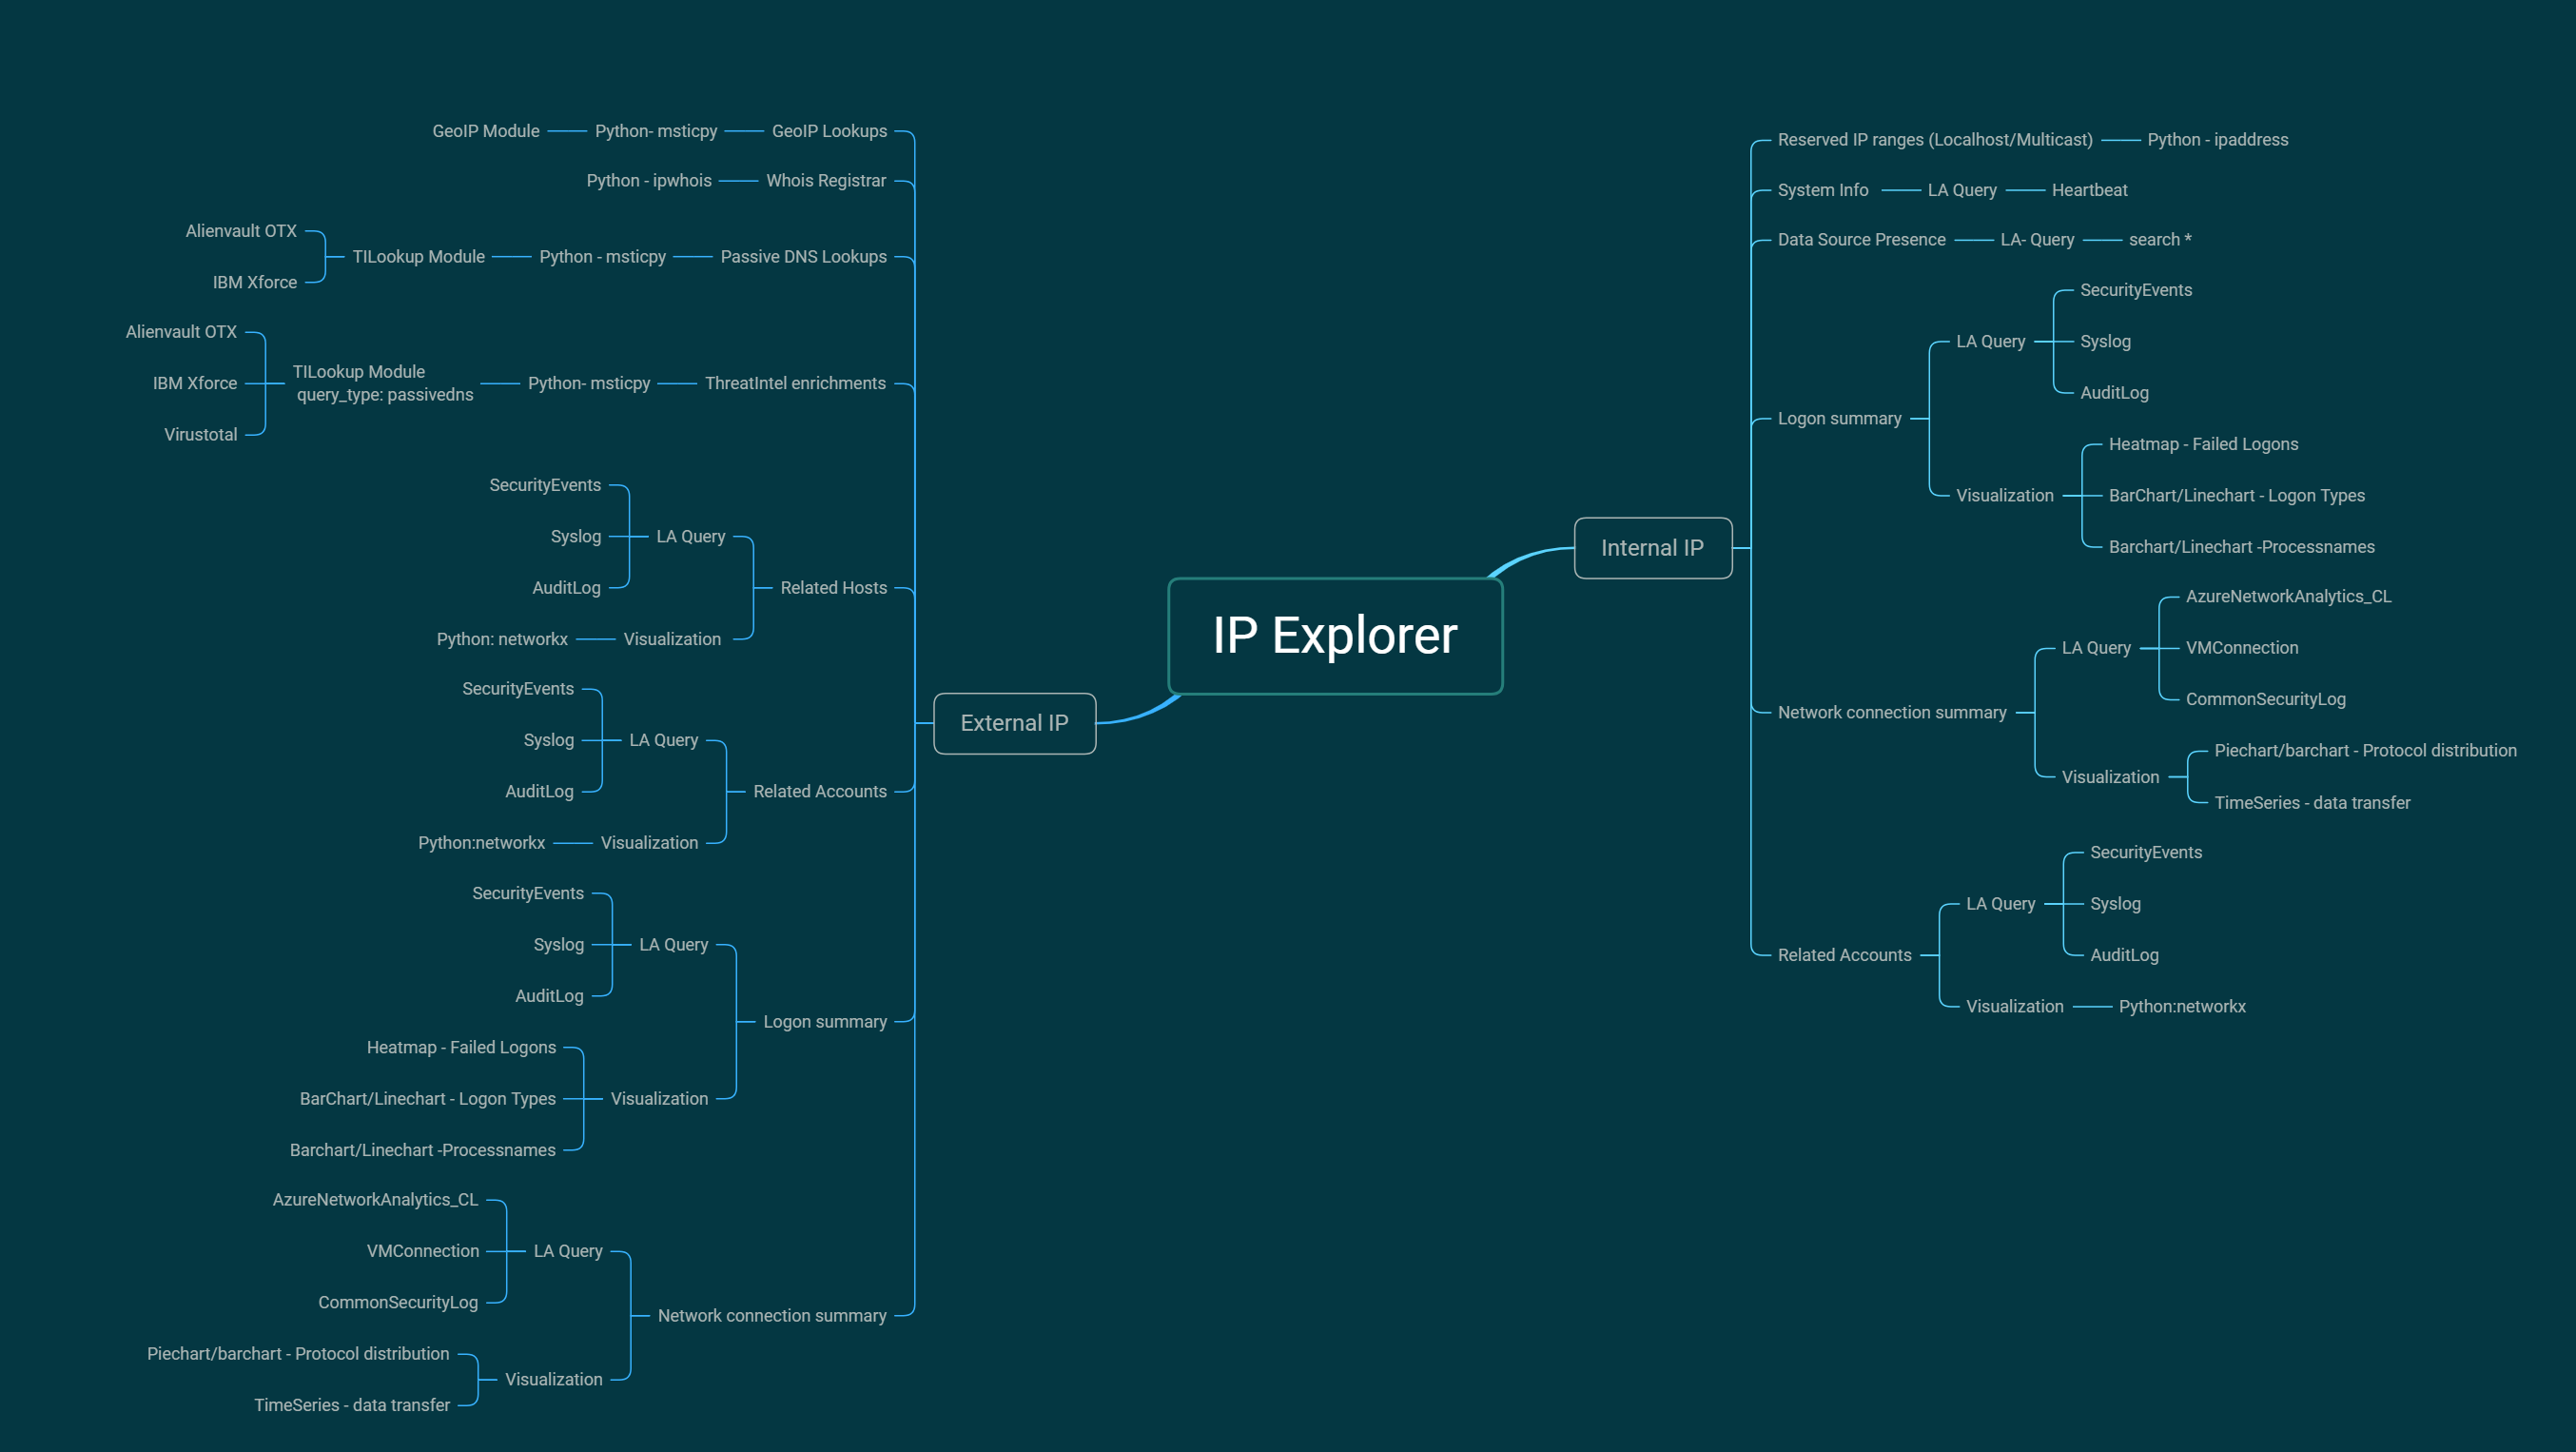

<a></a>[Contents](#toc)
## Notebook Initialization
&lt;details&gt;
    <summary> <u>More Details...</u></summary>
        If this is your first time running this Notebook please run the cells in the <a>Setup</a> section before proceeding  to ensure you have the required packages installed correctly. Similarly if you see any import failures (```ImportError```) in the notebook, please make sure that you have run the <a>Setup</a> section first.
&lt;/details&gt;

In [7]:
# Imports
import sys
import warnings

from msticpy.nbtools.utility import check_py_version

MIN_REQ_PYTHON = (3, 6)
check_py_version(MIN_REQ_PYTHON)

from IPython import get_ipython
from IPython.display import display, HTML, Markdown
import ipywidgets as widgets

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#setting pandas display options for dataframe
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_colwidth", 100)

import re
import ipaddress as ip
import urllib.request
import json
import requests
from pathlib import Path
from pyvis.network import Network
import networkx as nx

# msticpy imports
from msticpy.data import QueryProvider
from msticpy.nbtools.entityschema import IpAddress, GeoLocation
from msticpy.nbtools import *
from msticpy.sectools import *
from msticpy.sectools.ip_utils import create_ip_record, get_ip_type, get_whois_info
from msticpy.nbtools.foliummap import FoliumMap
from msticpy.nbtools.utility import md, md_warn, check_and_install_missing_packages
from msticpy.nbtools.wsconfig import WorkspaceConfig

WIDGET_DEFAULTS = {
    "layout": widgets.Layout(width="95%"),
    "style": {"description_width": "initial"},
}

# Some of our dependencies (networkx) still use deprecated Matplotlib
# APIs - we can't do anything about it so suppress them from view
from matplotlib import MatplotlibDeprecationWarning

warnings.simplefilter("ignore", category=MatplotlibDeprecationWarning)

ws_config = WorkspaceConfig()

<a></a>[Contents](#toc)
### Get WorkspaceId and Authenticate to Log Analytics 
&lt;details&gt;
    <summary> <u>Details...</u></summary>
If you are using user/device authentication, run the following cell. 
- Click the 'Copy code to clipboard and authenticate' button.
- This will pop up an Azure Active Directory authentication dialog (in a new tab or browser window). The device code will have been copied to the clipboard. 
- Select the text box and paste (Ctrl-V/Cmd-V) the copied value. 
- You should then be redirected to a user authentication page where you should authenticate with a user account that has permission to query your Log Analytics workspace.

Use the following syntax if you are authenticating using an Azure Active Directory AppId and Secret:
```
%kql loganalytics://tenant(aad_tenant).workspace(WORKSPACE_ID).clientid(client_id).clientsecret(client_secret)
```
instead of
```
%kql loganalytics://code().workspace(WORKSPACE_ID)
```

Note: you may occasionally see a JavaScript error displayed at the end of the authentication - you can safely ignore this.<br>
On successful authentication you should see a ```popup schema``` button.
To find your Workspace Id go to [Log Analytics](https://ms.portal.azure.com/#blade/HubsExtension/Resources/resourceType/Microsoft.OperationalInsights%2Fworkspaces). Look at the workspace properties to find the ID.
&lt;/details&gt;

In [9]:
# Authentication
qry_prov = QueryProvider(data_environment="LogAnalytics")
qry_prov.connect(connection_str=ws_config.code_connect_str)
table_index = qry_prov.schema_tables

<IPython.core.display.Javascript object>

AttributeError: schema_tables is not a valid attribute.

<a></a>[Contents](#toc)
# Enter the IP Address and query time window

Type the IP address you want to search for and the time bounds over which search.

You can specify the IP address value in the widget e.g. 192.168.1.1

In [12]:
ipaddr_text = widgets.Text(
    description="Enter the IP Address to search for:", **WIDGET_DEFAULTS
)
display(ipaddr_text)

Text(value='', description='Enter the IP Address to search for:', layout=Layout(width='95%'), style=Descriptio…

In [13]:
query_times = nbwidgets.QueryTime(units="day", max_before=20, before=5, max_after=7)
query_times.display()

HTML(value='<h4>Set query time boundaries</h4>')

In [14]:
# Set up function to allow easy reference to common parameters for queries throughout the notebook
def ipaddr_query_params():
    return {
        "start": query_times.start,
        "end": query_times.end,
        "ip_address": ipaddr_text.value
    }

<a></a>[Contents](#toc)
## Detemine IP Address Type

In [44]:
ipaddr_type = get_ip_type(ipaddr_query_params()['ip_address'])

#TO DO - mention heatrtbeat table presence. explain what internal means ? 
md(f'Depending on the IP Address origin, different sections of this notebook are applicable', styles=["bold", "large"])
md(f'Please follow either the Interal IP Address or External IP Address sections', styles=["bold"])

#Get details from Heartbeat table for the given IP Address and Time Parameters
heartbeat_df = qry_prov.Heartbeat.get_info_by_ipaddress(**ipaddr_query_params())

# Set hostnames retrived from Heartbeat table if available
if not heartbeat_df.empty:
    hostname = heartbeat_df["Computer"][0]
else:
    hostname = ""
    
if not heartbeat_df.empty:
    ipaddr_origin = "Internal"
    md(f'IP Address IP Address type: {ipaddr_type}', styles=["blue","bold"])
    md(f'Go to section [InternalIP](#goto_internalIP)', "bold, blue, large")
else:
    ipaddr_type = "External"
    md(f'IP Address type: {ipaddr_type}', styles=["orange","bold"])
    md('Go to section: [ExternalIP](#goto_externalIP)', styles=["blue","bold"])
    
#Populate related IP addresses for the calculated hostname
az_net_df = None
if "AzureNetworkAnalytics_CL" in table_index:
    aznet_query = f"""AzureNetworkAnalytics_CL | where ResourceType == 'NetworkInterface' | where SubType_s == "Topology" | search \'{ipaddr_text.value}\' | where TimeGenerated >= datetime({query_times.start}) | where TimeGenerated <= datetime({query_times.end}) | where VirtualMachine_s has '{hostname}' | top 1 by TimeGenerated desc | project PrivateIPAddresses = PrivateIPAddresses_s, PublicIPAddresses = PublicIPAddresses_s"""
    az_net_df = qry_prov.exec_query(query=aznet_query)
    
#Create IP Entity record using available dataframes
if az_net_df.empty and heartbeat_df.empty:
    md_warn('No Heartbeat Data and Network topology data found')
elif heartbeat_df:
    if az_net_df:
        ip_entity = create_ip_record(
            heartbeat_df=heartbeat_df, az_net_df=az_net_df)
    else:
        ip_entity = create_ip_record(
            heartbeat_df=heartbeat_df)
    #Display IP Entity 
    print(ip_entity)

<p style="font-weight: bold; font-size: 130%;">Depending on the IP Address origin, different sections of this notebook are applicable</p>

<p style="font-weight: bold;">Please follow either the Interal IP Address or External IP Address sections</p>

<p style="">IP Address type: External</p>

<p style="color: blue; font-weight: bold;">Go to section: [ExternalIP](#goto_externalIP)</p>

<p style="font-weight: bold; color: red; font-size: 130%;">Warning: No Heartbeat Data and Network topology data found</p>

<a></a>[Contents](#toc)
# Data Sources available to query related to IP

In [45]:
# KQL query for full text search of IP address and display all datatypes populated for the time period
datasource_status = """
search \'{ip_address}\' or \'{hostname}\'
| where TimeGenerated >= datetime({start}) and TimeGenerated <= datetime({end})
| summarize RowCount=count() by Table=$table
""".format(
    **ipaddr_query_params(), hostname=hostname
)
%kql -query datasource_status
datasource_status_df = _kql_raw_result_.to_dataframe()

# Display result as transposed matrix of datatypes availabel to query for the query period
if not datasource_status_df.empty:
    available_datasets = datasource_status_df['Table'].values
    md("Datasources available to query for IP ::", styles=["green","bold"])
    display(datasource_status_df)
else:
    md("No datasources available to query for the query period", styles=["red","bold"])

<p style="color: red; font-weight: bold;">No datasources available to query for the query period</p>

In [49]:
# Get single event - try process creation
if 
if "SecurityEvent" not in available_datasets:
    raise ValueError("No Windows event log data available in the workspace")
host_name = None
matching_hosts_df = qry_prov.WindowsSecurity.list_host_processes(
    query_times, host_name=hostname, add_query_items="| distinct Computer"
)
elif :
    if "Syslog" not in available_datasets:
        raise ValueError("No Linux syslog data available in the workspace")
    else:
        linux_syslog_query = f""" Syslog | where TimeGenerated >= datetime({query_times.start}) | where TimeGenerated <= datetime({query_times.end}) | where HostIP == '{ipaddr_text.value}' | distinct Computer """
        linux_syslog_df = qry_prov.exec_query(query=linux_syslog_query)
        
if len(matching_hosts_df) > 1:
    print(f"Multiple matches for '{hostname}'. Please select a host from the list.")
    choose_host = nbwidgets.SelectString(
        item_list=list(matching_hosts_df["Computer"].values),
        description="Select the host.",
        auto_display=True,
    )
elif not matching_hosts_df.empty:
    host_name = matching_hosts_df["Computer"].iloc[0]
    print(f"Unique host found for IP: {hostname}")

NameError: name 'available_datasets' is not defined

<a></a>
# Internal IP Address

<a></a>[Contents](#toc)
## System Info

In [26]:
#TODO - strip the output to certain columns
# Retrieving System info from internal table if IP address is not Public
if ipaddr_origin == "Internal":
    md(
            'System Info retrieved from Heartbeat table ::', styles=["green","bold"]
        )
    display(heartbeat_df.T)
else:
        md_warn(
            'No records available in HeartBeat table'
        )

<p style="color: green; font-weight: bold;">System Info retrieved from Heartbeat table ::</p>

,0
TimeGenerated,2019-10-30 00:13:48.787000
Computer,WinAttackSim
ComputerIP,104.211.48.180
ComputerEnvironment,Azure
SubscriptionId,40dcc8bf-0478-4f3b-b275-ed0a94f2c013
ResourceType,virtualMachines
OSType,Windows
OSName,
OSMajorVersion,10
OSMinorVersion,0


[Contents](#toc)
## ServiceMap - Get List of Services for Host

In [28]:
if "ServiceMapProcess_CL" not in table_index:
        md_warn("ServiceMap data is not enabled")
        md(
            f"Enable ServiceMap Solution from Azure marketplce: <br>"
            +"https://docs.microsoft.com/en-us/azure/azure-monitor/insights/service-map#enable-service-map",
            styles=["bold"]
        )

else:
    servicemap_proc_query = """
    ServiceMapProcess_CL
    | where Computer == \'{hostname}\'
    | where TimeGenerated >= datetime({starttime}) and TimeGenerated <= datetime({endtime})
    | project Computer, Services_s, DisplayName_s, ExecutableName_s , ExecutablePath_s 
        """.format(
        hostname=hostname, **ipaddr_query_params()
    )

    %kql -query servicemap_proc_query
    servicemap_proc_df = _kql_raw_result_.to_dataframe()

<p style="font-weight: bold; color: red; font-size: 130%;">Warning: ServiceMap data is not enabled</p>

<p style="font-weight: bold;">Enable ServiceMap Solution from Azure marketplce: <br>https://docs.microsoft.com/en-us/azure/azure-monitor/insights/service-map#enable-service-map</p>

<a></a>
# External IP

<a></a>[Contents](#toc)
## GeoIP Lookups for External IP Addresses

## <font>IH Comment
This doesn't seem right. Are you confusing "Public" with external. Not a big deal I guess but you still might want to run some of these for IPs that you own.

I think I mentioned this before but it would be good to distinguish "public" - i.e. externally routable IP from "external" - i.e. not owned by us (the org that the user of the notebook belongs to).</font>

In [56]:
# msticpy- geoip module to retrieving Geo Location for Public IP addresses
if ipaddr_type == "Public":
    iplocation = GeoLiteLookup()

    loc_results, ext_ip_entity = iplocation.lookup_ip(ip_address=ipaddr_query_params()['ip_address'])
    md(
            'Geo Location for the IP Address ::', styles=["bold","green"]
        )
    print(ext_ip_entity[0])
else:
    md('Not an ExternalIP', styles=["bold","red"])

<p style="font-weight: bold; color: green;">Geo Location for the IP Address ::</p>

{ 'AdditionalData': {},
  'Address': '104.211.48.180',
  'Location': { 'AdditionalData': {},
                'City': 'Washington',
                'CountryCode': 'US',
                'CountryName': 'United States',
                'Latitude': 38.7095,
                'Longitude': -78.1539,
                'State': 'Virginia',
                'Type': 'geolocation'},
  'Type': 'ipaddress'}


<a></a>[Contents](#toc)
## Whois Registrars for External IP Addresses

In [31]:
# ipwhois module to retrieve whois registrar for Public IP addresses
if ipaddr_type == "Public":
    from ipwhois import IPWhois

    whois = IPWhois(ipaddr_query_params()['ip_address'])
    whois_result = whois.lookup_whois()
    if whois_result:
        md(f'### Whois Registrar Info ::', styles=["bold","green"])
        display(whois_result)
    else:
        md(
                f'### <span style="color:orange"> No whois records available </span>', styles=["bold","orange"]
            )
else:
    md('Not an ExternalIP', styles=["bold","red"])

<p style="font-weight: bold; color: green;">### Whois Registrar Info ::</p>

{'nir': None,
 'asn_registry': 'arin',
 'asn': '8075',
 'asn_cidr': '104.208.0.0/13',
 'asn_country_code': 'US',
 'asn_date': '2014-10-01',
 'asn_description': 'MICROSOFT-CORP-MSN-AS-BLOCK - Microsoft Corporation, US',
 'query': '104.211.48.180',
 'nets': [{'cidr': '104.208.0.0/13',
   'name': 'MSFT',
   'handle': 'NET-104-208-0-0-1',
   'range': '104.208.0.0 - 104.215.255.255',
   'description': 'Microsoft Corporation',
   'country': 'US',
   'state': 'WA',
   'city': 'Redmond',
   'address': 'One Microsoft Way',
   'postal_code': '98052',
   'emails': ['msndcc@microsoft.com',
    'IOC@microsoft.com',
    'abuse@microsoft.com'],
   'created': '2014-10-01',
   'updated': '2014-10-01'}],
 'raw': None,
 'referral': None,
 'raw_referral': None}

<a></a>[Contents](#toc)
## Opensource and Azure Sentinel ThreatIntel Lookups

### Configure your TI Provider settings
If you have not used threat intelligence lookups before you will need to supply API keys for the 
TI Providers that you want to use. Please see the section on configuring [msticpyconfig.yaml](#msticpyconfig.yaml-configuration-File)

Then reload provider settings:
```
mylookup = TILookup()
mylookup.reload_provider_settings()
```

In [36]:
if ipaddr_type == "Public":
    pkg_config.settings
    mylookup = TILookup()
    mylookup.loaded_providers
    resp = mylookup.lookup_ioc(observable=ipaddr_query_params()['ip_address'], ioc_type="ipv4")
    md(f'ThreatIntel Lookup for IP ::', styles=["bold","green"])
    display(mylookup.result_to_df(resp).T)
else:
    md('Not an ExternalIP', styles=["bold","red"])

<p style="font-weight: bold; color: green;">ThreatIntel Lookup for IP ::</p>

,OTX,XForce
Ioc,104.211.48.180,104.211.48.180
IocType,ipv4,ipv4
QuerySubtype,None,None
Provider,OTX,XForce
Result,True,True
Severity,0,1
Details,"{'pulse_count': 0, 'sections_available': ['general', 'geo', 'reputation', 'url_list', 'passive_d...","{'score': 1, 'cats': {}, 'categoryDescriptions': {}, 'reason': 'Regional Internet Registry', 're..."
RawResult,"{'sections': ['general', 'geo', 'reputation', 'url_list', 'passive_dns', 'malware', 'nids_list',...","{'ip': '104.211.48.180', 'history': [{'created': '2014-10-02T06:27:00.000Z', 'reason': 'Regional..."
Reference,https://otx.alienvault.com/api/v1/indicators/IPv4/104.211.48.180/general,https://api.xforce.ibmcloud.com/ipr/104.211.48.180
Status,0,0


<a></a>[Contents](#toc)
## Passive DNS lookups for External IP Addresses

In [39]:
pdns_df["RawResult"][0]

{'Passive': {'query': '0x00000000000000000000ffff68d330b4', 'records': []},
 'total_rows': 0}

In [44]:
if ipaddr_type == "Public":
    # retrieve passive dns from TI Providers
    pdns = mylookup.lookup_ioc(
        observable=ipaddr_query_params()['ip_address'],
        ioc_type="ipv4",
        ioc_query_type="passivedns",
        providers=["XForce"],
    )
    pdns_df = mylookup.result_to_df(pdns)
    if not pdns_df.empty and pdns_df["RawResult"][0] and "RDNS" in pdns_df["RawResult"][0]:
        pdnsdomains = pdns_df["RawResult"][0]["RDNS"]
        md(
                'Passive DNS domains for IP: {pdnsdomains}',styles=["bold","green"]
            )
        display(mylookup.result_to_df(pdns).T)
    else:
        md(
                'No passive domains found from the providers', styles=["bold","orange"]
            )
else:
    md('Not an ExternalIP', styles=["bold","red"])

<p style="font-weight: bold;">No passive domains found from the providers</p>

# Related Alerts

In [45]:
ra_query_times = nbwidgets.QueryTime(
    units="day",
    origin_time=query_times.origin_time,
    max_before=28,
    max_after=5,
    before=5,
    auto_display=True,
)


HTML(value='<h4>Set query time boundaries</h4>')

## Visualization - Timeline of Related Alerts

In [46]:
#TODO - testing the alerts query - ASC schema 
# include bookmar/other relevant tables.
related_alerts = qry_prov.SecurityAlert.list_related_alerts(
    ra_query_times, host_name=hostname
)


def print_related_alerts(alertDict, entityType, entityName):
    if len(alertDict) > 0:
        md(
                f"Found {len(alertDict)} different alert types related to this {entityType} (`{entityName}`)",styles=["bold","orange"]
            )
        for (k, v) in alertDict.items():
            print(f"- {k}, # Alerts: {v}")
    else:
        print(f"No alerts for {entityType} entity `{entityName}`")


if isinstance(related_alerts, pd.DataFrame) and not related_alerts.empty:
    host_alert_items = (
        related_alerts[["AlertName", "TimeGenerated"]]
        .groupby("AlertName")
        .TimeGenerated.agg("count")
        .to_dict()
    )
    print_related_alerts(host_alert_items, "host", hostname)
    nbdisplay.display_timeline(
        data=related_alerts, title="Alerts", source_columns=["AlertName"], height=200
    )
else:
    md("No related alerts found.",styles=["bold","green"])

<p style="font-weight: bold; color: green;">No related alerts found.</p>

 ## Browse List of Related Alerts
 Select an Alert to view details

In [47]:
def disp_full_alert(alert):
    global related_alert
    related_alert = SecurityAlert(alert)
    nbdisplay.display_alert(related_alert, show_entities=True)

recenter_wgt = widgets.Checkbox(
    value=True,
    description='Center subsequent query times round selected Alert?',
    disabled=False,
    **WIDGET_DEFAULTS
)
if related_alerts is not None and not related_alerts.empty:
    related_alerts["CompromisedEntity"] = related_alerts["Computer"]
    md("Click on alert to view details.", styles=["bold"])
    display(recenter_wgt)
    rel_alert_select = nbwidgets.AlertSelector(
        alerts=related_alerts,
        action=disp_full_alert,
    )
    rel_alert_select.display()

<a></a>[Contents](#toc)
# Related Hosts
**Hypothesis:** That an attacker has gained  access to the host, compromized credentials for the accounts and laterally moving to the network gaining access to more hosts.

This section provides related hosts of IP address which is being investigated. .If you wish to expand the scope of hunting then investigate each hosts in detail, it is recommended that to use the **Host Explorer Notebook (include link).**

<a></a>[Contents](#toc)
## Visualization - Networkx Graph

### IH Comment - no labels on IP Addresses (not super important)

<p style="font-weight: bold; color: green;">Entity Relationship Graph - Related Hosts :: </p>

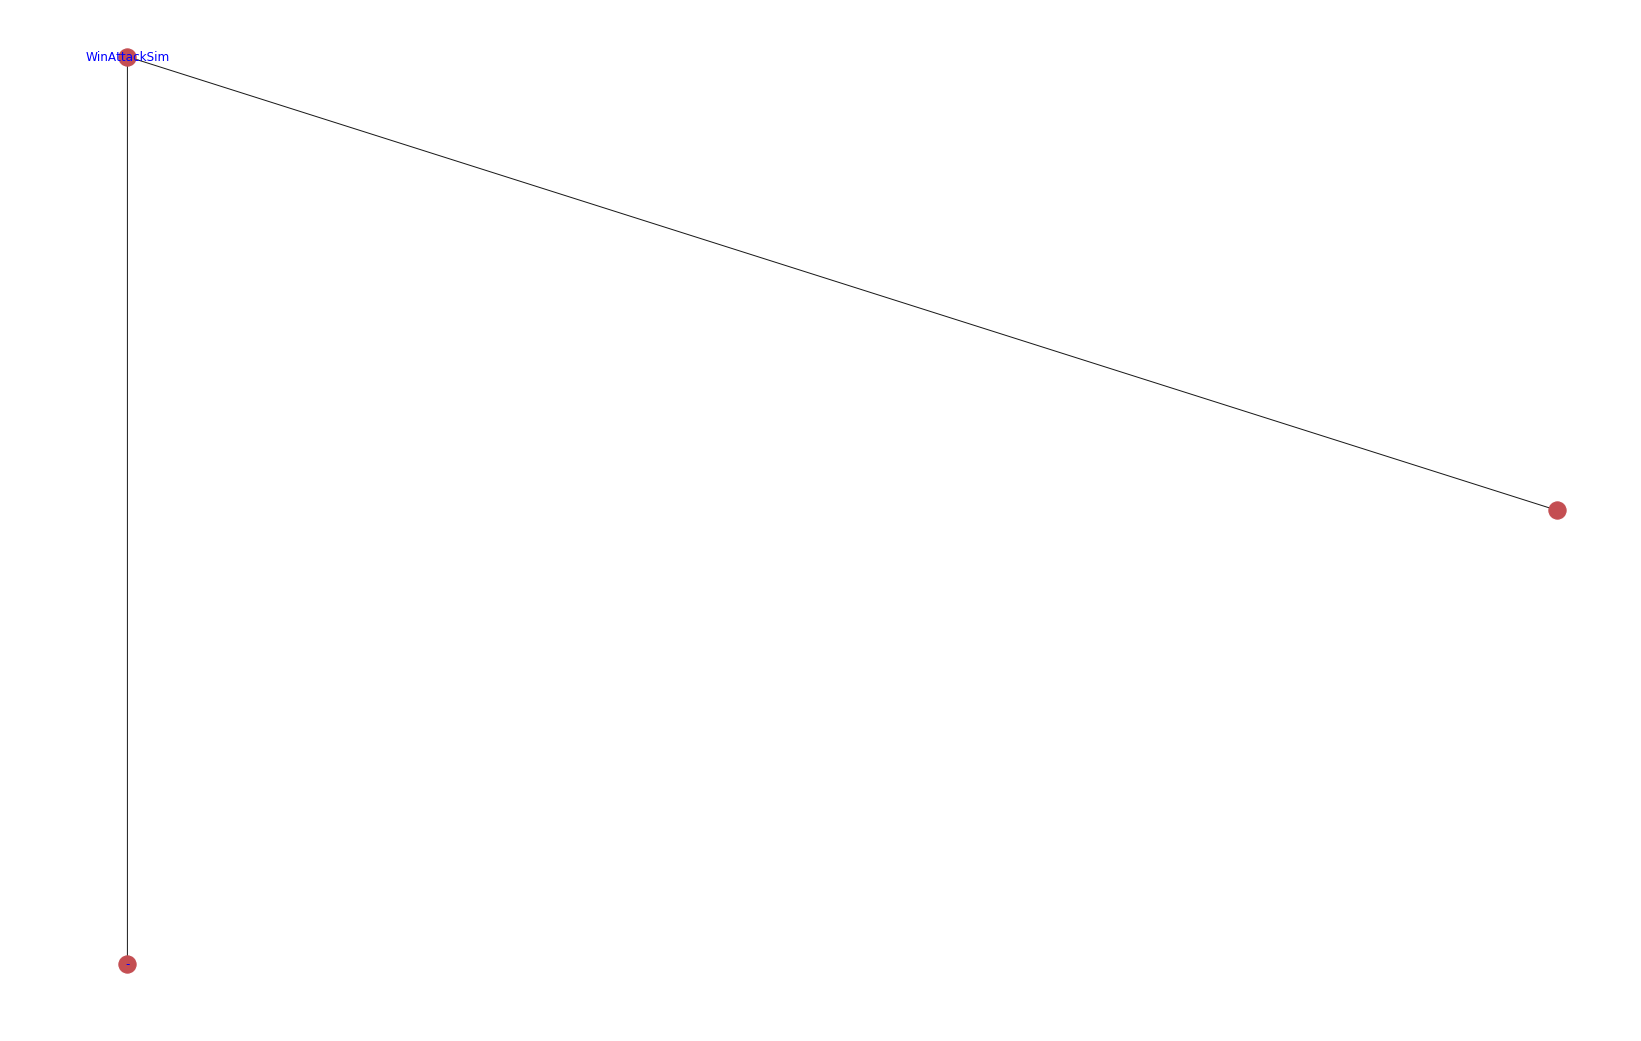

In [48]:
# Retrived relatd accounts from SecurityEvent table for Windows OS
if (
    "SecurityEvent" in datasource_status_df.values
    and heartbeat_df["OSType"][0] == "Windows"
):
    related_hosts = """
       SecurityEvent
       | where TimeGenerated >= datetime({start}) and TimeGenerated <= datetime({end})
       | where IpAddress == \'{ip_address}\' or Computer == \'{hostname}\'      
       | summarize count() by Computer, IpAddress
    """.format(
        **ipaddr_query_params(), hostname=hostname
    )
    %kql -query related_hosts
    related_hosts_df = _kql_raw_result_.to_dataframe()

#     got_net = Network(notebook=True, height="750px", width="100%", bgcolor="#222222", font_color="white")

#     # set the physics layout of the network
#     got_net.barnes_hut()

#     sources = related_hosts_df['Computer']
#     targets = related_hosts_df['IpAddress']
#     weights = related_hosts_df['count_']

#     edge_data = zip(sources, targets, weights)

#     for e in edge_data:
#         src = e[0]
#         dst = e[1]
#         w = e[2]

#     got_net.add_node(src, src, title=src)
#     got_net.add_node(dst, dst, title=dst)
#     got_net.add_edge(src, dst, value=w)

#     neighbor_map = got_net.get_adj_list()

#     # add neighbor data to node hover data
#     for node in got_net.nodes:
#         node["title"] += " Neighbors:<br>" + "<br>".join(neighbor_map[node["id"]])
#         node["value"] = len(neighbor_map[node["id"]]) # this value attrribute for the node affects node size

#     got_net.show("example.html")

    
# Uncomment- below cells if above visualization does not render - Networkx connected Graph
    plt.figure(10, figsize=(22, 14))
    g = nx.from_pandas_edgelist(related_hosts_df, "IpAddress", "Computer")
    md('Entity Relationship Graph - Related Hosts :: ',styles=["bold","green"])
    nx.draw_circular(g, with_labels=True, size=40, font_size=12, font_color="blue")
else:
    logon_events = qry_prov.LinuxSyslog.host_logon(invest_times, host_name=hostname)

<a></a>[Contents](#toc)
# Related Accounts
**Hypothesis:** That an attacker has gained  access to the host, compromized credentials for the accounts on it and laterally moving to the network gaining access to more accounts.

This section provides related accounts of IP address which is being investigated. .If you wish to expand the scope of hunting then investigate each accounts in detail, it is recommended that to use the **Account Explorer Notebook (include link).**

<a></a>[Contents](#toc)
## Visualization - Networkx Graph

<p style="font-weight: bold; color: green;">Entity Relationship Graph - Related Accounts :: </p>

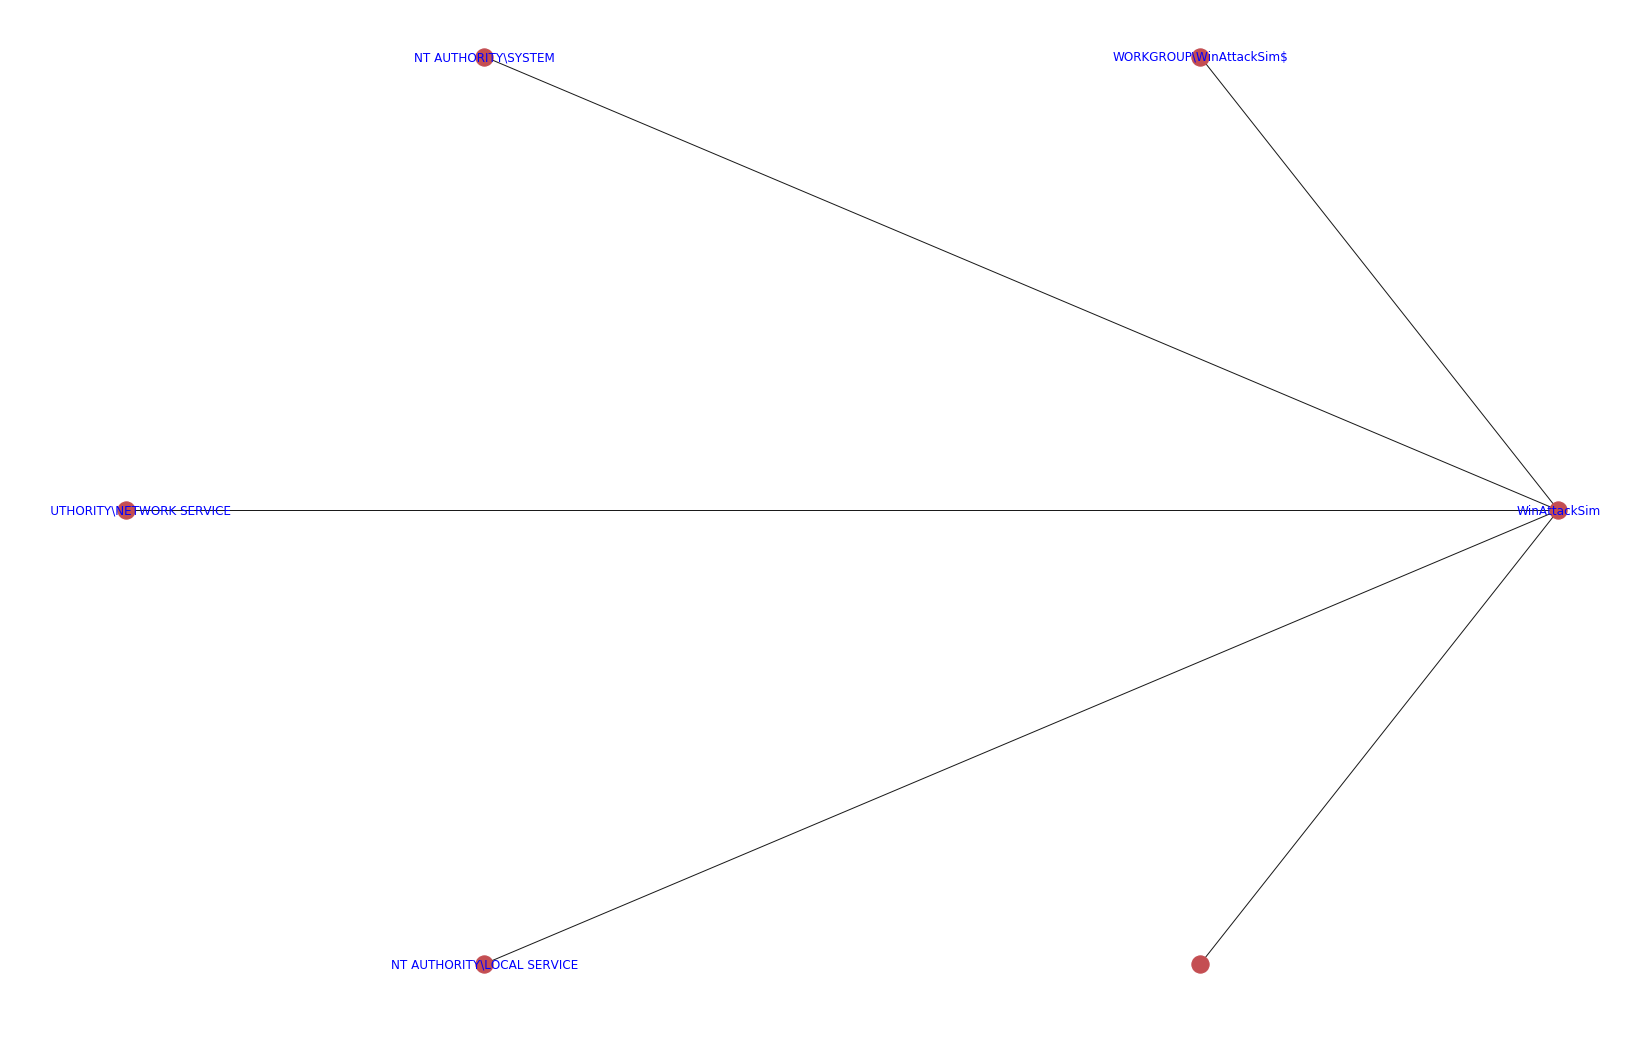

In [49]:
# Retrived relatd accounts from SecurityEvent table for Windows OS
if (
    "SecurityEvent" in available_datasets
    and heartbeat_df["OSType"][0] == "Windows"
):
    related_accounts = """
       SecurityEvent
       | where TimeGenerated >= datetime({start}) and TimeGenerated <= datetime({end})
       | where IpAddress == \'{ip_address}\' or Computer == \'{hostname}\'       
       | summarize count() by Account, Computer
    """.format(
        **ipaddr_query_params(), hostname=hostname
    )
    %kql -query related_accounts
    related_accounts_df = _kql_raw_result_.to_dataframe()
    got_net = Network(notebook=True, height="750px", width="100%", bgcolor="#222222", font_color="white")

    # set the physics layout of the network
    got_net.barnes_hut()


    sources = related_accounts_df['Computer']
    targets = related_accounts_df['Account']
    weights = related_accounts_df['count_']

    edge_data = zip(sources, targets, weights)

    for e in edge_data:
        src = e[0]
        dst = e[1]
        w = e[2]

        got_net.add_node(src, src, title=src)
        got_net.add_node(dst, dst, title=dst)
        got_net.add_edge(src, dst, value=w)

    neighbor_map = got_net.get_adj_list()

    # add neighbor data to node hover data
    for node in got_net.nodes:
        node["title"] += " Neighbors:<br>" + "<br>".join(neighbor_map[node["id"]])
        node["value"] = len(neighbor_map[node["id"]]) # this value attrribute for the node affects node size

    got_net.show("example.html")

# Uncomment- below cells if above visualization does not render - Networkx connected Graph
    plt.figure(10, figsize=(22, 14))
    g = nx.from_pandas_edgelist(related_accounts_df, "Computer", "Account")
    md('Entity Relationship Graph - Related Accounts :: ',styles=["bold","green"])
    nx.draw_circular(g, with_labels=True, size=40, font_size=12, font_color="blue")
else:
    # TODO: Need to pull linux table data/similar query for linux
    print("Need to query Linux data table")

<a></a>[Contents](#toc)
# Logon Summary for Related Entities
**Hypothesis:** By analyzing logon activities of the related entities, we can identify change in logon patterns and narrow down the entities to few suspicious logon patterns.

This section provides various visualization of logon attributes such as 
- Weekly Failed Logon trend
- Logon Types 
- Logon Processes

If you wish to expand the scope of hunting then investigate specific host in detail, it is recommended that to use the **Host Explorer Notebook (include link).**

<a></a>[Contents](#toc)
## HeatMap for Weekly failed logons

###  <span style="color: blue;"> Heatmap- Weekly Failed Logon Trend :: </span>

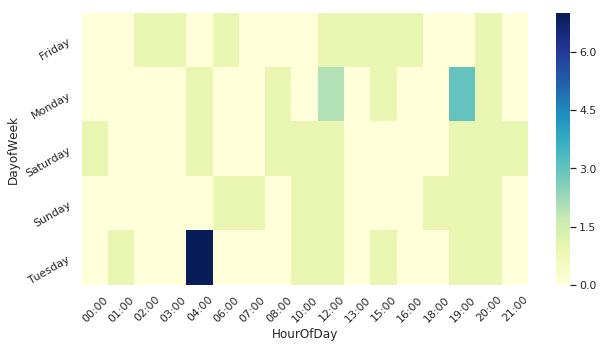

In [50]:
# Retrived relatd accounts from SecurityEvent table for Windows OS
if (
    "SecurityEvent" in available_datasets
    and heartbeat_df["OSType"][0] == "Windows"
):
    failed_logons = """
       SecurityEvent
        | where EventID in (4624,4625) | where IpAddress == \'{ip_address}\' or Computer == \'{hostname}\'  
        | where TimeGenerated >= datetime({start}) and TimeGenerated <= datetime({end})
        | extend DayofWeek = case(dayofweek(TimeGenerated) == time(1.00:00:00), "Monday", 
                            dayofweek(TimeGenerated) == time(2.00:00:00), "Tuesday",
                            dayofweek(TimeGenerated) == time(3.00:00:00), "Wednesday",
                            dayofweek(TimeGenerated) == time(4.00:00:00), "Thursday",
                            dayofweek(TimeGenerated) == time(5.00:00:00), "Friday",
                            dayofweek(TimeGenerated) == time(6.00:00:00), "Saturday",
                            "Sunday")
        | summarize LogonCount=count() by DayofWeek, HourOfDay=format_datetime(bin(TimeGenerated,1h),'HH:mm')
    """.format(
        **ipaddr_query_params(), hostname=hostname
    )
    %kql -query failed_logons
    failed_logons_df = _kql_raw_result_.to_dataframe()

else:  # TODO Logs for othher
    print("No relevant Log data source available")

# Plotting hearmap using seaborn library if there are failed logons
if len(failed_logons_df) > 0:
    df_pivot = (
        failed_logons_df.reset_index()
        .pivot_table(index="DayofWeek", columns="HourOfDay", values="LogonCount")
        .fillna(0)
    )
    display(
        Markdown(
            f'###  <span style="color:blue"> Heatmap - Weekly Failed Logon Trend :: </span>'
        )
    )
    f, ax = plt.subplots(figsize=(10, 5))
    hm1 = sns.heatmap(df_pivot, cmap="YlGnBu", ax=ax)
    plt.xticks(rotation=45)
    plt.yticks(rotation=30)
else:
    linux_logons=qry_prov.LinuxSyslog.list_logons_for_source_ip(**ipaddr_query_params())
    failed_logons = (logon_events[logon_events['LogonResult'] == 'Failure'])

<a></a>[Contents](#toc)
## Host Logons Timeline

In [51]:
# set the origin time to the time of our alert
try:
    origin_time = (related_alert.TimeGenerated 
                   if recenter_wgt.value 
                   else query_times.origin_time)
except NameError:
    origin_time = query_times.origin_time
    
logon_query_times = nbwidgets.QueryTime(
    units="day",
    origin_time=origin_time,
    before=5,
    after=1,
    max_before=20,
    max_after=20,
)
logon_query_times.display()

HTML(value='<h4>Set query time boundaries</h4>')

In [52]:
host_logons = qry_prov.WindowsSecurity.list_host_logons(
    logon_query_times, host_name=hostname
)

if host_logons is not None and not host_logons.empty:
    display(Markdown("### Logon timeline."))
    tooltip_cols = [
        "TargetUserName",
        "TargetDomainName",
        "SubjectUserName",
        "SubjectDomainName",
        "LogonType",
        "IpAddress",
    ]
    nbdisplay.display_timeline(
        data=host_logons,
        group_by="TargetUserName",
        source_columns=tooltip_cols,
        legend_column="TargetUserName",
        legend="right", yaxis=True
    )

    display(Markdown("### Counts of logon events by logon type."))
    display(Markdown("Min counts for each logon type highlighted."))
    logon_by_type = (
        host_logons[["Account", "LogonType", "EventID"]]
        .astype({'LogonType': 'int32'})
        .merge(right=pd.Series(data=nbdisplay._WIN_LOGON_TYPE_MAP, name="LogonTypeDesc"),
               left_on="LogonType", right_index=True)
        .drop(columns="LogonType")
        .groupby(["Account", "LogonTypeDesc"])
        .count()
        .unstack()
        .rename(columns={"EventID": "LogonCount"})
        .fillna(0)
        .style
        .background_gradient(cmap="viridis", low=0.5, high=0)
        .format("{0:0>3.0f}")
    )
    display(logon_by_type)
else:
    display(Markdown("No logon events found for host."))


### Logon timeline.

Loading BokehJS ...

### Counts of logon events by logon type.

Min counts for each logon type highlighted.

,LogonCount
LogonTypeDesc,Service
Account,
NT AUTHORITY\SYSTEM,045


## Failed Logons Timeline

In [55]:
ip_entity

[IpAddress(Type=ipaddress, Address=104.211.48.180, Location={ 'AdditionalData': {},
   'City...)]

In [58]:
failedLogons = qry_prov.WindowsSecurity.list_host_logon_failures(
    logon_query_times, host_name=ip_entity.hostname
)
if failedLogons.empty:
    print("No logon failures recorded for this host between ",
          f" {logon_query_times.start} and {logon_query_times.end}"
        )
else:
    nbdisplay.display_timeline(
        data=host_logons.query('TargetLogonId != "0x3e7"'),
        overlay_data=failedLogons,
        alert=related_alert,
        title="Logons (blue=user-success, green=failed)",
        source_columns=tooltip_cols,
        height=200,
    )
    display(failedLogons
 .astype({'LogonType': 'int32'})
 .merge(right=pd.Series(data=nbdisplay._WIN_LOGON_TYPE_MAP, name="LogonTypeDesc"),
               left_on="LogonType", right_index=True)
 [['Account', 'EventID', 'TimeGenerated',
  'Computer', 'SubjectUserName', 'SubjectDomainName',
   'TargetUserName', 'TargetDomainName',
   'LogonTypeDesc','IpAddress', 'WorkstationName'
  ]])

No logon failures recorded for this host between   2019-10-25 00:14:16.741677 and 2019-10-31 00:14:16.741677


<a></a>[Contents](#toc)
# Network Connection Analysis

**Hypothesis:** That an attacker is remotely communicating with the host in order to compromise the host or for outbound communication to C2 for data exfiltration purposes after compromising the host.

This section provides an overview of network activity to and from the host during hunting time frame, the purpose of this is for the identification of anomalous network traffic. If you wish to investigate a specific IP in detail it is recommended that to use another instance of this notebook with each IP addresses.

<a></a>[Contents](#toc)
## Network Check Communications with Other Hosts

In [59]:
ip_q_times = nbwidgets.QueryTime(
    label="Set time bounds for network queries",
    units="day",
    max_before=28,
    before=2,
    after=5,
    max_after=28,
    origin_time=logon_query_times.origin_time
)
ip_q_times.display()

HTML(value='<h4>Set time bounds for network queries</h4>')

<a></a>[Contents](#toc)
### Query Flows by IP Address

In [65]:
if "AzureNetworkAnalytics_CL" not in available_datasets:
    md_warn("No network flow data available.")
    md("Please skip the remainder of this section and go to [Time-Series-Anomalies](#Outbound-Data-transfer-Time-Series-Anomalies)")
    az_net_comms_df = None
else:
    all_host_ips = (
        ip_entity['private_ips'] + ip_entity['public_ips']
    )
    host_ips = [i.Address for i in all_host_ips]

    az_net_comms_df = qry_prov.Network.list_azure_network_flows_by_ip(
        ip_q_times, ip_address_list=host_ips
    )

    if isinstance(az_net_comms_df, pd.DataFrame) and not az_net_comms_df.empty:
        az_net_comms_df['TotalAllowedFlows'] = az_net_comms_df['AllowedOutFlows'] + az_net_comms_df['AllowedInFlows']
        nbdisplay.display_timeline(
            data=az_net_comms_df,
            group_by="L7Protocol",
            title="Network Flows by Protocol",
            time_column="FlowStartTime",
            source_columns=["FlowType", "AllExtIPs", "L7Protocol", "FlowDirection"],
            height=300,
            legend="right",
            yaxis=True
        )
        nbdisplay.display_timeline(
            data=az_net_comms_df,
            group_by="FlowDirection",
            title="Network Flows by Direction",
            time_column="FlowStartTime",
            source_columns=["FlowType", "AllExtIPs", "L7Protocol", "FlowDirection"],
            height=300,
            legend="right",
            yaxis=True
        )
    else:
        md_warn("No network data for specified time range.")
        md("Please skip the remainder of this section and go to [Time-Series-Anomalies](#Outbound-Data-transfer-Time-Series-Anomalies)")

<p style="font-weight: bold; color: red; font-size: 130%;">Warning: No network flow data available.</p>

<p style="">Please skip the remainder of this section and go to [Time-Series-Anomalies](#Outbound-Data-transfer-Time-Series-Anomalies)</p>

In [66]:

flow_plot = nbdisplay.display_timeline_values(data=az_net_comms_df,
                                  group_by="L7Protocol",
                                  source_columns=["FlowType", 
                                                  "AllExtIPs", 
                                                  "L7Protocol", 
                                                  "FlowDirection", 
                                                  "TotalAllowedFlows"],
                                  time_column="FlowStartTime",
                                  y="TotalAllowedFlows",
                                  legend="right",
                                  legend_column="L7Protocol", 
                                  height=500,
                                  kind=["vbar", "circle"]);

Loading BokehJS ...

TypeError: 'NoneType' object is not subscriptable

In [67]:
if az_net_comms_df is not None and not az_net_comms_df.empty:
    cm = sns.light_palette("green", as_cmap=True)

    cols = [
        "VMName",
        "VMIPAddress",
        "PublicIPs",
        "SrcIP",
        "DestIP",
        "L4Protocol",
        "L7Protocol",
        "DestPort",
        "FlowDirection",
        "AllExtIPs",
        "TotalAllowedFlows",
    ]
    flow_index = az_net_comms_df[cols].copy()

    def get_source_ip(row):
        if row.FlowDirection == "O":
            return row.VMIPAddress if row.VMIPAddress else row.SrcIP
        else:
            return row.AllExtIPs if row.AllExtIPs else row.DestIP

    def get_dest_ip(row):
        if row.FlowDirection == "O":
            return row.AllExtIPs if row.AllExtIPs else row.DestIP
        else:
            return row.VMIPAddress if row.VMIPAddress else row.SrcIP

    flow_index["source"] = flow_index.apply(get_source_ip, axis=1)
    flow_index["dest"] = flow_index.apply(get_dest_ip, axis=1)

    # Uncomment to view flow_index results
#     with warnings.catch_warnings():
#         warnings.simplefilter("ignore")
#         display(
#             flow_index[
#                 ["source", "dest", "L7Protocol", "FlowDirection", "TotalAllowedFlows"]
#             ]
#             .groupby(["source", "dest", "L7Protocol", "FlowDirection"])
#             .sum()
#             .reset_index()
#             .style.bar(subset=["TotalAllowedFlows"], color="#d65f5f")
#         )

In [68]:
# WHOIS lookup function
from functools import lru_cache
from ipwhois import IPWhois
from ipaddress import ip_address


# Add ASN informatio from Whois
flows_df = (
    flow_index[["source", "dest", "L7Protocol", "FlowDirection", "TotalAllowedFlows"]]
    .groupby(["source", "dest", "L7Protocol", "FlowDirection"])
    .sum()
    .reset_index()
)

num_ips = len(flows_df["source"].unique()) + len(flows_df["dest"].unique())
print(f"Performing WhoIs lookups for {num_ips} IPs ", end="")
#flows_df = flows_df.assign(DestASN="", DestASNFull="", SourceASN="", SourceASNFull="")
flows_df["DestASN"] = flows_df.apply(lambda x: get_whois_info(x.dest, True), axis=1)
flows_df["SourceASN"] = flows_df.apply(lambda x: get_whois_info(x.source, True), axis=1)
print("done")

# Split the tuple returned by get_whois_info into separate columns
flows_df["DestASNFull"] = flows_df.apply(lambda x: x.DestASN[1], axis=1)
flows_df["DestASN"] = flows_df.apply(lambda x: x.DestASN[0], axis=1)
flows_df["SourceASNFull"] = flows_df.apply(lambda x: x.SourceASN[1], axis=1)
flows_df["SourceASN"] = flows_df.apply(lambda x: x.SourceASN[0], axis=1)

our_host_asns = [get_whois_info(ip.Address)[0] for ip in ip_entity.public_ips]
md(f"Host {ip_entity.hostname} ASNs:", "bold")
md(str(our_host_asns))

flow_sum_df = flows_df.groupby(["DestASN", "SourceASN"]).agg(
    TotalAllowedFlows=pd.NamedAgg(column="TotalAllowedFlows", aggfunc="sum"),
    L7Protocols=pd.NamedAgg(column="L7Protocol", aggfunc=lambda x: x.unique().tolist()),
    source_ips=pd.NamedAgg(column="source", aggfunc=lambda x: x.unique().tolist()),
    dest_ips=pd.NamedAgg(column="dest", aggfunc=lambda x: x.unique().tolist()),
).reset_index()
flow_sum_df

NameError: name 'flow_index' is not defined

### Choose ASNs/IPs to Check for Threat Intel Reports
Choose from the list of Selected ASNs for the IPs you wish to check on.
The Source list is been pre-populated with all ASNs found in the network flow summary.

As an example, we've populated the `Selected` list with the ASNs that have the lowest number of flows to and from the host. We also remove the ASN that matches the ASN of the host we are investigating.

Please edit this list, using flow summary data above as a guide and leaving only ASNs that you are suspicious about. Typicially these would be ones with relatively low `TotalAllowedFlows` and possibly with unusual `L7Protocols`.

In [53]:
all_asns = list(flow_sum_df["DestASN"].unique()) + list(flow_sum_df["SourceASN"].unique())
all_asns = set(all_asns) - set(["private address"])

# Select the ASNs in the 25th percentile (lowest number of flows)
quant_25pc = flow_sum_df["TotalAllowedFlows"].quantile(q=[0.25]).iat[0]
quant_25pc_df = flow_sum_df[flow_sum_df["TotalAllowedFlows"] <= quant_25pc]
other_asns = list(quant_25pc_df["DestASN"].unique()) + list(quant_25pc_df["SourceASN"].unique())
other_asns = set(other_asns) - set(our_host_asns)
md("Choose IPs from Selected ASNs to look up for Threat Intel.", "bold")
sel_asn = nbwidgets.SelectSubset(source_items=all_asns, default_selected=other_asns)

<p style="font-weight: bold;">Choose IPs from Selected ASNs to look up for Threat Intel.</p>

In [57]:
ti_lookup = TILookup()
from itertools import chain
dest_ips = set(chain.from_iterable(flow_sum_df[flow_sum_df["DestASN"].isin(sel_asn.selected_items)]["dest_ips"]))
src_ips = set(chain.from_iterable(flow_sum_df[flow_sum_df["SourceASN"].isin(sel_asn.selected_items)]["source_ips"]))
selected_ips = dest_ips | src_ips
print(f"{len(selected_ips)} unique IPs in selected ASNs")

# Add the IoCType to save cost of inferring each item
selected_ip_dict = {ip: "ipv4" for ip in selected_ips}
ti_results = ti_lookup.lookup_iocs(data=selected_ip_dict)

print(f"{len(ti_results)} results received.")

# ti_results_pos = ti_results[ti_results["Severity"] > 0]
#####
# WARNING - faking results for illustration purposes
#####
ti_results_pos = ti_results.sample(n=2)

print(f"{len(ti_results_pos)} positive results found.")


if not ti_results_pos.empty:
    src_pos = flows_df.merge(ti_results_pos, left_on="source", right_on="Ioc")
    dest_pos = flows_df.merge(ti_results_pos, left_on="dest", right_on="Ioc")
    ti_ip_results = pd.concat([src_pos, dest_pos])
    md_warn("Positive Threat Intel Results found for the following flows")
    md("Please examine these IP flows using the IP Explorer notebook.", "bold, large")
    display(ti_ip_results)

5 unique IPs in selected ASNs
17 results received.
2 positive results found.


<p style="font-weight: bold; color: red; font-size: 130%;">Warning: Positive Threat Intel Results found for the following flows</p>

<p style="font-weight: bold; font-size: 130%;">Please examine these IP flows using the IP Explorer notebook.</p>

,source,dest,L7Protocol,FlowDirection,TotalAllowedFlows,DestASN,SourceASN,DestASNFull,SourceASNFull,Ioc,IocType,QuerySubtype,Provider,Result,Severity,Details,RawResult,Reference,Status
0,10.0.3.5,205.185.216.10,http,O,4.0,"HIGHWINDS3 - Highwinds Network Group, Inc., US",NO ASN Information since IP address is of type,"{'nir': None, 'asn_registry': 'arin', 'asn': '20446', 'asn_cidr': '205.185.216.0/24', 'asn_count...",{Private},205.185.216.10,ipv4,None,XForce,False,0,Authorization failed. Check account and key details.,<Response [401]>,https://api.xforce.ibmcloud.com/ipr/205.185.216.10,401
1,10.0.3.5,205.185.216.42,http,O,1.0,"HIGHWINDS3 - Highwinds Network Group, Inc., US",NO ASN Information since IP address is of type,"{'nir': None, 'asn_registry': 'arin', 'asn': '20446', 'asn_cidr': '205.185.216.0/24', 'asn_count...",{Private},205.185.216.42,ipv4,None,XForce,False,0,Authorization failed. Check account and key details.,<Response [401]>,https://api.xforce.ibmcloud.com/ipr/205.185.216.42,401


 ## GeoIP Map of External IPs

In [69]:
iplocation = GeoLiteLookup()
def format_ip_entity(row, ip_col):
    ip_entity = entities.IpAddress(Address=row[ip_col])
    iplocation.lookup_ip(ip_entity=ip_entity)
    ip_entity.AdditionalData["protocol"] = row.L7Protocol
    if "severity" in row:
        ip_entity.AdditionalData["threat severity"] = row["severity"]
    if "Details" in row:
        ip_entity.AdditionalData["threat details"] = row["Details"]
    return ip_entity

# from msticpy.nbtools.foliummap import FoliumMap
folium_map = FoliumMap()
if az_net_comms_df is None or az_net_comms_df.empty:
    print("No network flow data available.")
else:
    # Get the flow records for all flows not in the TI results
    selected_out = flows_df[flows_df["DestASN"].isin(sel_asn.selected_items)]
    selected_out = selected_out[~selected_out["dest"].isin(ti_ip_results["Ioc"])]
    if selected_out.empty:
        ips_out = []
    else:
        ips_out = list(selected_out.apply(lambda x: format_ip_entity(x, "dest"), axis=1))
    
    selected_in = flows_df[flows_df["SourceASN"].isin(sel_asn.selected_items)]
    selected_in = selected_in[~selected_in["source"].isin(ti_ip_results["Ioc"])]
    if selected_in.empty:
        ips_in = []
    else:
        ips_in = list(selected_in.apply(lambda x: format_ip_entity(x, "source"), axis=1))

    ips_threats = list(ti_ip_results.apply(lambda x: format_ip_entity(x, "Ioc"), axis=1))

    display(HTML("<h3>External IP Addresses communicating with host</h3>"))
    display(HTML("Numbered circles indicate multiple items - click to expand"))
    display(HTML("Location markers: <br>Blue = outbound, Purple = inbound, Green = Host, Red = Threats"))

    icon_props = {"color": "green"}
    for ips in ip_entity.public_ips:
        ips.AdditionalData["host"] = ip_entity.hostname
    folium_map.add_ip_cluster(ip_entities=ip_entity.public_ips, **icon_props)
    icon_props = {"color": "blue"}
    folium_map.add_ip_cluster(ip_entities=ips_out, **icon_props)
    icon_props = {"color": "purple"}
    folium_map.add_ip_cluster(ip_entities=ips_in, **icon_props)
    icon_props = {"color": "red"}
    folium_map.add_ip_cluster(ip_entities=ips_threats, **icon_props)
    
    display(folium_map)

No network flow data available.


<a></a>[Contents](#toc)
## Outbound Data transfer Time Series Anomalies

This section will look into the network datasources to check outbound data transfer trends. 
You can also use time series analysis using below built-in KQL query example to analyze anamalous data transfer trends.below example shows sample dataset trends comparing with actual vs baseline traffic trends.

### IH Comment - would be good to check that PaloAltoBytesSent_CL exists before running second section.

In [70]:
if "VMConnection" in table_index or "CommonSecurityLog" in table_index:
    # KQL query for full text search of IP address and display all datatypes
    dataxfer_stats = """
      union isfuzzy=true
      (
      CommonSecurityLog 
      | where TimeGenerated >= datetime({start}) and TimeGenerated <= datetime({end})
      | where isnotempty(DestinationIP) and isnotempty(SourceIP)
      | where SourceIP == \'{ip_address}\'
      | extend SentBytesinKB = (SentBytes / 1024), ReceivedBytesinKB = (ReceivedBytes / 1024)
      | summarize DailyCount = count(), ListOfDestPorts = make_set(DestinationPort), TotalSentBytesinKB = sum(SentBytesinKB), TotalReceivedBytesinKB = sum(ReceivedBytesinKB) by SourceIP, DestinationIP, DeviceVendor, bin(TimeGenerated,1d)
      | project DeviceVendor, TimeGenerated, SourceIP, DestinationIP, ListOfDestPorts, TotalSentBytesinKB, TotalReceivedBytesinKB 
      ),
      (
      VMConnection 
      | where TimeGenerated >= datetime({start}) and TimeGenerated <= datetime({end}) 
      | where isnotempty(DestinationIp) and isnotempty(SourceIp)
      | where SourceIp == \'{ip_address}\'
      | extend DeviceVendor = "VMConnection", SourceIP = SourceIp, DestinationIP = DestinationIp
      | extend SentBytesinKB = (BytesSent / 1024), ReceivedBytesinKB = (BytesReceived / 1024)
      | summarize DailyCount = count(), ListOfDestPorts = make_set(DestinationPort), TotalSentBytesinKB = sum(SentBytesinKB),TotalReceivedBytesinKB = sum(ReceivedBytesinKB) by SourceIP, DestinationIP, DeviceVendor, bin(TimeGenerated,1d)
      | project DeviceVendor, TimeGenerated, SourceIP, DestinationIP, ListOfDestPorts, TotalSentBytesinKB, TotalReceivedBytesinKB 
      )
    """.format(**ipaddr_query_params())
    %kql -query dataxfer_stats
    dataxfer_stats_df = _kql_raw_result_.to_dataframe()

timechartquery = """
let TimeSeriesData = PaloAltoBytesSent_CL
| extend TimeGenerated = todatetime(EventTime_s), TotalBytesSent = todouble(TotalBytesSent_s) 
| summarize TimeGenerated=make_list(TimeGenerated, 10000),TotalBytesSent=make_list(TotalBytesSent, 10000) by deviceVendor_s
| project TimeGenerated, TotalBytesSent;
TimeSeriesData
| extend (baseline,seasonal,trend,residual) = series_decompose(TotalBytesSent)
| mv-expand TotalBytesSent to typeof(double), TimeGenerated to typeof(datetime), baseline to typeof(long), seasonal to typeof(long), trend to typeof(long), residual to typeof(long)
| project TimeGenerated, TotalBytesSent, baseline
| render timechart with (title="Palo Alto Outbound Data Transfer Time Series decomposition")
"""
%kql -query timechartquery

# Display result as transposed matrix of datatypes availabel to query for the query period
# if len(dataxfer_stats_df) > 0:
#     display(
#         Markdown(
#             f'###  <span style="color:blue"> Data transfer daily stats for IP :: </span>'
#         )
#     )
#     display(dataxfer_stats_df)
# else:
#     display(
#         Markdown(
#             f'### <span style="color:orange"> No Data transfer logs found for the query period </span>'
#         )
#     )

# Conclusion

## List of Suspicious Activities/ Observables/Hunting bookmarks
- Suspicious alerts for the IP
- Anamalous Failed Logon trend on few days at 04:00 AM
- Anamalous spike in traffic logs on http
- Positive TI Hit 

<a></a>[Contents](#toc)
# Appendices

## Available DataFrames

In [64]:
print('List of current DataFrames in Notebook')
print('-' * 50)
current_vars = list(locals().keys())
for var_name in current_vars:
    if isinstance(locals()[var_name], pd.DataFrame) and not var_name.startswith('_'):
        print(var_name)

List of current DataFrames in Notebook
--------------------------------------------------
heartbeat_df
az_net_df
datasource_status_df
matching_hosts_df
related_alerts
related_hosts_df
related_accounts_df
failed_logons_df
df_pivot
host_logons
failedLogons
az_net_comms_df
flow_index
flows_df
flow_sum_df
quant_25pc_df
ti_results
ti_results_pos
src_pos
dest_pos
ti_ip_results
selected_out
selected_in


## Saving Data to Excel
To save the contents of a pandas DataFrame to an Excel spreadsheet
use the following syntax
```
writer = pd.ExcelWriter('myWorksheet.xlsx')
my_data_frame.to_excel(writer,'Sheet1')
writer.save()
```

<a></a> [Contents](#toc)
# Setup Cell
If you have not run this Notebook before please run this cell before running the rest of the Notebook.

In [3]:
#!pip install git+https://github.com/microsoft/msticpy --upgrade --user

In [5]:
import sys
import warnings
from msticpy.nbtools.utility import check_and_install_missing_packages

from IPython import get_ipython
from IPython.display import display, HTML, Markdown
import ipywidgets as widgets

warnings.filterwarnings("ignore", category=DeprecationWarning)


MIN_REQ_PYTHON = (3, 6)
if sys.version_info < MIN_REQ_PYTHON:
    print("Check the Kernel->Change Kernel menu and ensure that Python 3.6")
    print("or later is selected as the active kernel.")
    sys.exit("Python %s.%s or later is required.\n" % MIN_REQ_PYTHON)

WIDGET_DEFAULTS = {
    "layout": widgets.Layout(width="95%"),
    "style": {"description_width": "initial"},
}

# Missing Package installation
required_packages = ["ipwhois","folium","dnspython","pyvis"]
check_and_install_missing_packages(required_packages)

Missing packages to be installed::  ipwhois folium dnspython pyvis


pyvis installed succesfully



## `msticpyconfig.yaml` configuration File
You can configure primary and secondary TI providers and any required parameters in the `msticpyconfig.yaml` file. This is read from the current directory or you can set an environment variable (`MSTICPYCONFIG`) pointing to its location.

Primary providers are used by default. Secondary providers can be invoked by using the `providers` parameter to lookup_ioc or lookup_iocs. `providers` should be a list of strings identifying the provider to use. The provider ID is given by the `Provider:` setting for each of the TI providers.

For most providers you will usually need to supply an authorization (API) key and in some cases a user ID for each provider.

For LogAnalytics/Azure Sentinel providers, you will need the workspace ID and tenant ID and will need to authenticate in order to access the data (although if you have an existing authenticated connection with the same workspace/tenant, this connection will be re-used). You can use a different workspace for TI from the one you are working in.

If you need to create a config file, uncomment the lines in the following cell.

**Warning** - this will overwrite a file of the same name in the current directory

Delete any provider entries that you do not want to use and add the missing parameters for your providers.

In [ ]:
# %%writefile msticpyconfig.yaml

# AzureSentinel:
#   #Workspaces:
#   #  Default:
#   #    WorkspaceId: "52b1ab41-869e-4138-9e40-2a4457f09bf0"
#   #    TenantId: "4cdf87a8-f0fc-40bb-9d85-68bcf4ac8e61"
#   #  Workspace2:
#   #    WorkspaceId: "c88dd3c2-d657-4eb3-b913-58d58d811a41"
#   #    TenantId: "4cdf87a8-f0fc-40bb-9d85-68bcf4ac8e61"
#   #  Workspace3:
#   #    WorkspaceId: "17e64332-19c9-472e-afd7-3629f299300c"
#   #    TenantId: "4ea41beb-4546-4fba-890b-55553ce6003a"
# QueryDefinitions:
#   # Uncomment and add paths to folders containing custom query definitions here
#   #Custom:
#   #  - /home/myuser/queries
# TIProviders:
#   OTX:
#     Args:
#       AuthKey: "your-otx-key"
#     Primary: True
#     Provider: "OTX" # Explicitly name provider to override
#   VirusTotal:
#     Args:
#       AuthKey: "your-vt-key"
#     Primary: True
#     Provider: "VirusTotal"
#   XForce:
#     # You can store items in an environment variable using this syntax
#     Args:
#       ApiID:
#         EnvironmentVar: "XFORCE_ID"
#       AuthKey:
#         EnvironmentVar: "XFORCE_KEY"
#     Primary: True
#     Provider: "XForce"
#   AzureSentinel:
#     Args:
#       # Workspace and tenant where your ThreatIndicator table is
#       # - usually the same as your default workspace
#       WorkspaceID: "52b1ab41-869e-4138-9e40-2a4457f09bf0"
#       TenantID: "4cdf87a8-f0fc-40bb-9d85-68bcf4ac8e61"
#     Primary: True
#     Provider: "AzSTI"